In [1]:
import numbers
import math

import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import control
import control.matlab

import utility as util
import utility.npu

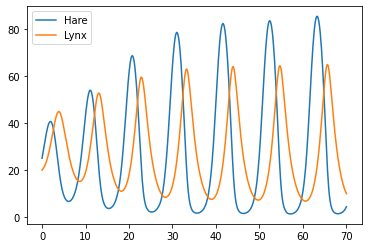

In [2]:
# Predator and prey
def predprey_rhs(t, x, u, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x[0]
    L = x[1]

    # Compute the control action (only allow addition of food)
    u_0 = u if u > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

io_predprey = control.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(io_predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
# plt.show(block=False)

In [3]:
"""
c.g. - center of gravity
x - position on x-axis in global frame
y - position on y-axis in global frame
psi - angle between car longitudinal axis and x-axis of global frame  
v - velocity at center of gravity
delta - angle between car front wheel and car longitudinal axis
beta - angle between car longitudinal axis and velocity vector from c.g.
L - length of vehicle
l_r - length between back wheel and c.g.
l_f - length between front wheel and c.g.
"""

sin = math.sin
cos = math.cos
atan = math.atan
tan = math.tan

def get_beta(delta, l_r=0.5, L=1.0):
    if l_r == L:
        return delta
    else:
        return atan((l_r / L)*tan(delta))

def get_dbeta_ddelta(delta, l_r=0.5, L=1.0):
    if l_r == L:
        return 1
    else:
        tan2 = tan(delta)**2
        return (1 + tan2) / ((L / l_r) + (l_r / L)*tan2)

def bicycle_kinematics(t, x, u, params):
    l_r = params.get('l_r', 0.5)
    L = params.get('L', 1)
    psi   = x[2]
    v     = x[3]
    delta = x[4]
    u_1, u_2 = u[0], u[1]
    beta  = get_beta(delta, l_r=l_r, L=L)
    return np.array([
        v*cos(psi + beta), # dot x 
        v*sin(psi + beta), # dot y
        (v / L)*cos(beta)*tan(delta), # dot psi
        u_1, # dot v
        u_2, # dot delta
    ])

def get_state_matrix(x, y, psi, v, delta, l_r=0.5, L=1.0):
    beta   = get_beta(delta, l_r=l_r, L=L)
    dbeta  = get_dbeta_ddelta(delta, l_r=l_r, L=L)
    df3_dv = (1/L)*cos(beta)*tan(delta)
    df3_ddelta = (v/L)*(cos(beta)*(1 + tan(delta)**2) - sin(beta)*tan(delta)*dbeta)
    return np.array([
        # x, y, psi, v, delta
        [0, 0, -v*sin(psi + beta), cos(psi + beta), -v*sin(psi + beta)*dbeta],
        [0, 0,  v*cos(psi + beta), sin(psi + beta),  v*cos(psi + beta)*dbeta],
        [0, 0,                  0,          df3_dv,               df3_ddelta],
        [0, 0,                  0,               0,                        0],
        [0, 0,                  0,               0,                        0],
    ])

def get_input_matrix():
    return np.array([
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
    ]).T

def get_output_matrix():
    return np.array([
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
    ])

def get_feedforward_matrix():
    return np.array([
        [0, 0],
        [0, 0],
    ])

(-0.11880707191821549,
 24.494948510282526,
 -19.78969450364352,
 3.5466334831172217)

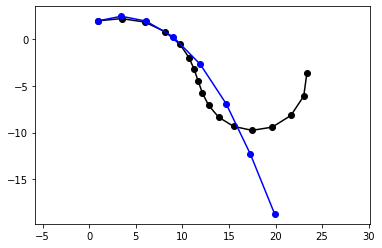

In [4]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = 0.15*0.5*np.pi
v_0 = 5.
delta_0 = - 0.05*0.5*np.pi

# Simulate the system (with discretization) but no linearization
io_bicycle_kinematics = control.NonlinearIOSystem(
        bicycle_kinematics, None,
        inputs=('u_1', 'u_2'),
        outputs=('x', 'y', 'psi', 'v', 'delta'),
        states=('x', 'y', 'psi', 'v', 'delta'),
        params={'l_r': 0.5, 'L': 1},
        name='bicycle_kinematics')

initial_state = [x_0, y_0, psi_0, v_0, delta_0]
T = 16
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
inputs = np.array([
    [ 0  ,  0   ],
    [ 0  , -0.05],
    [ 0  , -0.05],
    [-1.6,  0   ],
    [-1.6,  0   ],
    [-1.6,  0   ],
    [ 0  ,  0.15],
    [ 0  ,  0.15],
    [ 0.7,  0.15],
    [ 0.7,  0.15],
    [ 0.7,  0   ],
    [ 0.7,  0   ],
    [ 0.7,  0   ],
    [ 0.7,  0   ],
    [ 0.7,  0   ],
    [ 0  ,  0   ],
    [ 0  ,  0   ],
]).T

# Simulate the system
_timesteps, _states = control.input_output_response(
        io_bicycle_kinematics, timesteps, inputs, initial_state)
# Plot the response
plt.plot(_states[0], _states[1], "-ko")
plt.axis("equal")

# get state-space representation that linearly approximates dynamical system 
A = get_state_matrix(x_0, y_0, psi_0, v_0, delta_0, l_r=0.5, L=1.0)
B = get_input_matrix()
C = get_output_matrix()
D = get_feedforward_matrix()
# discretize state-space
Ts = 0.5
sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)
sys.A, sys.B

# Plot the linearization x(t + 1) = A x(t) + B u(t)
A = np.array(sys.A)
B = np.array(sys.B)
nx, nu = sys.B.shape
state_0 = np.array([x_0, y_0, psi_0, v_0, delta_0])

# Closed form solution to states given inputs
# C1 has shape (nx, T*nx)
C1 = np.zeros((nx, T*nx,))
# C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
C2 = np.kron(np.eye(T - 1), A)
# C3 has shape (nx*(T - 1), nx)
C3 = np.zeros(((T - 1)*nx, nx,))
# C, Abar have shape (nx*T, nx*T)
C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
Abar = np.eye(T * nx) - C
# Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
Bbar = np.kron(np.eye(T), B)
# Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))

# make state computation account for initial position and velocity
states_init = np.concatenate([np.linalg.matrix_power(A, t) @ state_0 for t in range(T+1)])
Z = states_init
u = inputs.T[:-1].ravel()
X = Z + Gamma @ u
X = X.reshape(-1, 5)
plt.plot(X[:8, 0], X[:8, 1], "-bo")
plt.axis("equal")

In [5]:
def gen_plot(initial_state, inputs, T, Ts, L=1.0, l_r=0.5):
    """
    initial_state : ndarray
        Initial state [x_0, y_0, psi_0, v_0, delta_0].
    inputs : ndarray
        Control inputs of shape (T, 2) [u_1, u_2]
    T : int
        Number of timesteps
    Ts : float
        Size of each timestep
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    timesteps = np.linspace(0, Ts*T, T + 1)
    inputs = np.concatenate( (inputs, np.array([0, 0])[None]), axis=0).T
    
    ## Plot the system without linearization

    # Simulate the system (with discretization) but no linearization
    io_bicycle_kinematics = control.NonlinearIOSystem(
            bicycle_kinematics, None,
            inputs=('u_1', 'u_2'),
            outputs=('x', 'y', 'psi', 'v', 'delta'),
            states=('x', 'y', 'psi', 'v', 'delta'),
            params={'l_r': l_r, 'L': L},
            name='bicycle_kinematics')
    _timesteps, _states = control.input_output_response(
            io_bicycle_kinematics, timesteps, inputs, initial_state)
    # Plot the response
    for ax in axes:
        ax.plot(_states[0], _states[1], "-ko")

    ## Plot the linearization x(t + 1) = A x(t) + B u(t)

    # get state-space representation that linearly approximates dynamical system 
    A = get_state_matrix(*initial_state, l_r=l_r, L=L)
    B = get_input_matrix()
    C = get_output_matrix()
    D = get_feedforward_matrix()
    # discretize state-space
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)
    A = np.array(sys.A)
    B = np.array(sys.B)
    nx, nu = sys.B.shape

    ## Plot open form of x(t + 1) = A x(t) + B u(t)
    U = inputs.T
    X = []
    state = initial_state
    X = [initial_state]
    for t in range(T):
        state = A @ state + B @ U[t]
        X.append(state)
    X = np.stack(X)
    axes[0].plot(X[:, 0], X[:, 1], "-ro", markersize=4)

    ## Plot closed form of x(t + 1) = A x(t) + B u(t)

    # Closed form solution to states given inputs
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))

    # make state computation account for initial position and velocity
    states_init = np.concatenate([np.linalg.matrix_power(A, t) @ initial_state for t in range(T+1)])
    u = inputs.T[:-1].ravel()
    X = states_init + Gamma @ u
    X = X.reshape(-1, 5)
    axes[1].plot(X[:, 0], X[:, 1], "-bo", markersize=4)
    for ax in axes:
        ax.axis("equal")

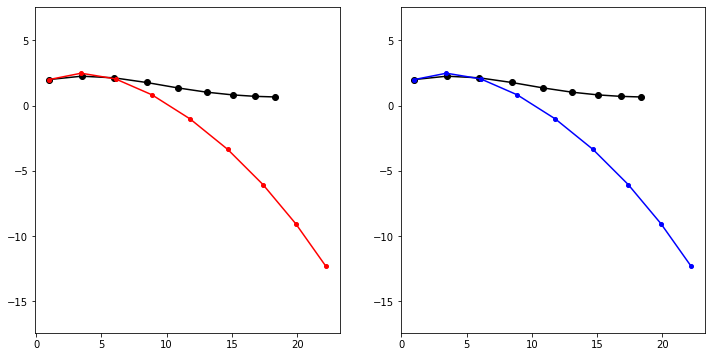

In [6]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = 0.15*0.5*np.pi
v_0 = 5.
delta_0 = - 0.05*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [ 0  , 0],
    [ 0  , 0.05],
    [ 0  , 0.05],
    [ 0  , 0.05],
    [-1  , 0.05],
    [-1  , 0],
    [-1  , 0],
    [-1  , 0],
])
gen_plot(initial_state, inputs, T, Ts)

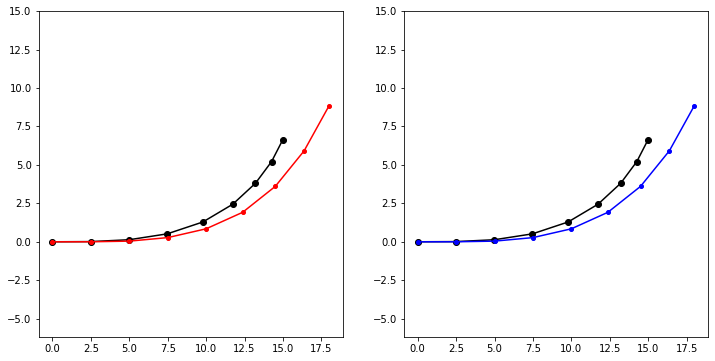

In [7]:
# initial state
x_0 = 0.
y_0 = 0.
psi_0 = 0.
v_0 = 5.
delta_0 = 0.
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [ 0  , 0],
    [ 0  , 0.05],
    [ 0  , 0.05],
    [ 0  , 0.05],
    [-1  , 0.05],
    [-1  , 0],
    [-1  , 0],
    [-1  , 0],
])
gen_plot(initial_state, inputs, T, Ts)

(0.031415926535897934, 0.7853981633974483)

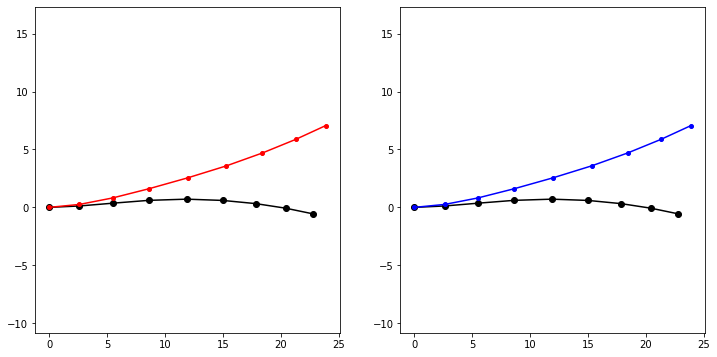

In [8]:
# initial state
x_0 = 0.
y_0 = 0.
psi_0 = 0.
v_0 = 5.
delta_0 = 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [ 1  ,-0.03],
    [ 1  ,-0.03],
    [ 1  ,-0.03],
    [ 1  ,-0.03],
    [-1  , 0],
    [-1  , 0],
    [-1  , 0],
    [-1  , 0],
])
gen_plot(initial_state, inputs, T, Ts)
delta_0, np.pi / 4

In [9]:
def plot_static_frame(initial_state, inputs, T, Ts, L=1.0, l_r=0.5):
    """
    initial_state : ndarray
        Initial state [x_0, y_0, psi_0, v_0, delta_0].
    inputs : ndarray
        Control inputs of shape (T, 2) [u_1, u_2]
    T : int
        Number of timesteps
    Ts : float
        Size of each timestep
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    timesteps = np.linspace(0, Ts*T, T + 1)
    inputs = np.concatenate( (inputs, np.array([0, 0])[None]), axis=0).T
    axes[0].plot(timesteps, inputs[0])
    axes[1].plot(timesteps, inputs[1])
    
    # change the frame so that local frame has x_0 = y_0 = 0, psi_0 = 0
    x_0, y_0, psi_0, v_0, delta_0 = initial_state
    initial_state_local = initial_state.copy()
    initial_state_local[:3] = np.array([0, 0, 0])
    # rigid transformation to convert local to global frame
    M = np.array([
        [cos(psi_0), -sin(psi_0), x_0],
        [sin(psi_0),  cos(psi_0), y_0],
    ])
    def transform(X):
        points = np.pad(X[:, :2], [(0, 0), (0, 1)], constant_values=1)
        points = points @ M.T
        psis   = X[:, 2] + psi_0
        return np.concatenate((points, psis[..., None], X[:, 3:]), axis=1)

    ## Plot the system without linearization

    # Simulate the system (with discretization) but no linearization
    io_bicycle_kinematics = control.NonlinearIOSystem(
            bicycle_kinematics, None,
            inputs=('u_1', 'u_2'),
            outputs=('x', 'y', 'psi', 'v', 'delta'),
            states=('x', 'y', 'psi', 'v', 'delta'),
            params={'l_r': l_r, 'L': L},
            name='bicycle_kinematics')
    _timesteps, _states = control.input_output_response(
            # io_bicycle_kinematics, timesteps, inputs, initial_state_local)
            io_bicycle_kinematics, timesteps, inputs, initial_state)
    # Plot the response
    # X = transform(_states.T)
    # plt.plot(X[:, 0], X[:, 1], "-ko")
    axes[2].plot(_states[0], _states[1], "-ko", label="bicycle kinemetics")

    ## Plot the linearization x(t + 1) = A x(t) + B u(t)

    # get state-space representation that linearly approximates dynamical system 
    A = get_state_matrix(*initial_state_local, l_r=l_r, L=L)
    B = get_input_matrix()
    C = get_output_matrix()
    D = get_feedforward_matrix()
    # discretize state-space
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)
    A = np.array(sys.A)
    B = np.array(sys.B)
    nx, nu = sys.B.shape

    ## Plot closed form of x(t + 1) = A x(t) + B u(t)

    # Closed form solution to states given inputs
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))

    # make state computation account for initial position and velocity
    states_init = np.concatenate([np.linalg.matrix_power(A, t) @ initial_state_local for t in range(T+1)])
    u = inputs.T[:-1].ravel()
    X = states_init + Gamma @ u
    X = X.reshape(-1, 5)
    X = transform(X)
    axes[2].plot(X[:, 0], X[:, 1], "-bo", markersize=4, label="local coords.+linearize")
    
    # car boxes
    vertex_set = util.npu.vertices_of_bboxes(X[:, :2], X[:, 2], np.array([3*L, 3*0.75*L]))
    for idx, vertices in enumerate(vertex_set):
        patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
        axes[2].add_patch(patch)
        # axes[2].arrow(X[idx, 0], X[idx, 1], X[idx, 3]*cos(X[idx, 2]), X[idx, 3]*sin(X[idx, 2]))
    
    # label points with timestep
    axes[2].text(*(X[0, :2] + np.array([0.5, 0.5])), "0", color="r", zorder=10)
    axes[2].text(*(X[1, :2] + np.array([0.5, 0.5])), "1", color="r", zorder=10)
    axes[2].text(*(X[2, :2] + np.array([0.5, 0.5])), "2", color="r", zorder=10)
    axes[2].text(*(X[3, :2] + np.array([0.5, 0.5])), "3", color="r", zorder=10)
    axes[2].text(*(X[4, :2] + np.array([0.5, 0.5])), "4", color="r", zorder=10)
    
    disp_errors = np.linalg.norm(_states.T[:, :2] - X[:, :2], axis=1)
    rot_errors  = np.abs(_states.T[:, 2] - X[:, 2])
    
    axes[3].plot(timesteps, disp_errors, label="$L^2$ displacement")
    axes[3].plot(timesteps, rot_errors, label="rotation")
    
    axes[2].legend()
    axes[3].legend()
    axes[2].axis("equal")
    axes[2].set_xlabel("x")
    axes[2].set_ylabel("y")
    axes[2].set_title("(x, y) positions over time")
    axes[0].set_xlabel("seconds")
    axes[0].set_ylabel("$\dot{v} = u_1$")
    axes[0].set_title("$\dot{v} = u_1$ control input over time")
    axes[1].set_xlabel("seconds")
    axes[1].set_ylabel("$\dot{\delta} = u_2$")
    axes[1].set_title("$\dot{\delta} = u_2$ control input over time")
    axes[3].set_xlabel("seconds")
    axes[3].set_ylabel("errors")
    axes[3].set_title("error of linearization over time")
    
    for ax in axes:
        ax.grid()
    # fig.tight_layout()
    fig.suptitle("Comparing kinematic model and its linearization\n"
                 "with initial values\n"
                 f"$x_0 = $ {np.round(x_0, 2)},   "
                 f"$y_0 = $ {np.round(y_0, 2)},   "
                 f"$\psi_0 = $ {np.round(psi_0, 2)},   "
                 f"$v_0 = $ {np.round(v_0, 2)},   "
                 f"$\delta_0 = $ {np.round(delta_0, 2)}", size="x-large")

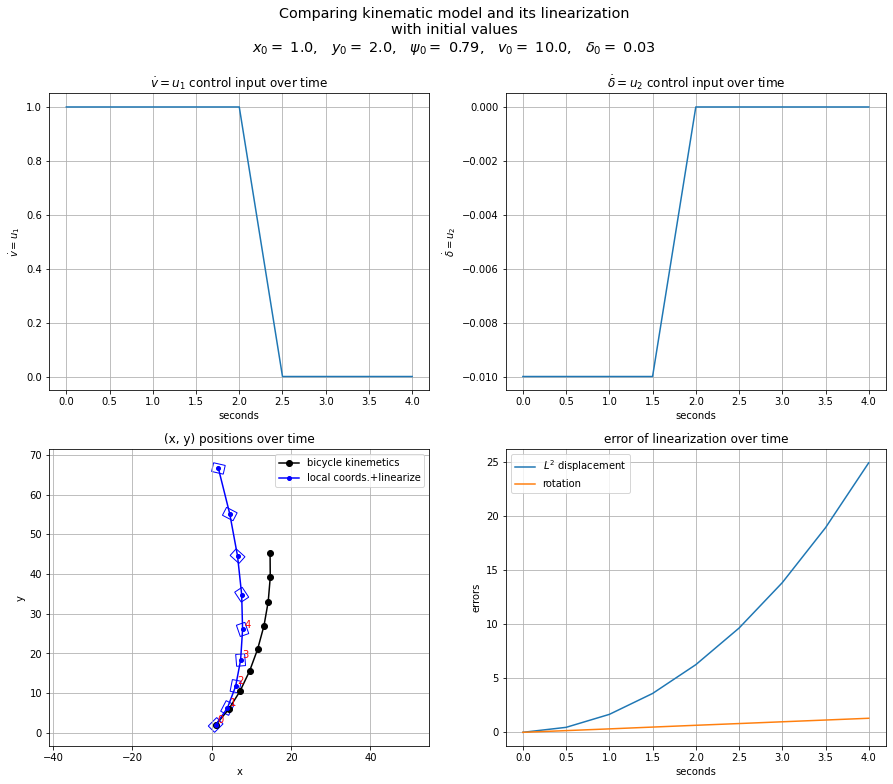

In [10]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = np.pi/4
v_0 = 10.0
delta_0 = 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: speed up and slight turn
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  , 0],
    [ 0  , 0],
    [ 0  , 0],
    [ 0  , 0],
])

plot_static_frame(initial_state, inputs, T, Ts)

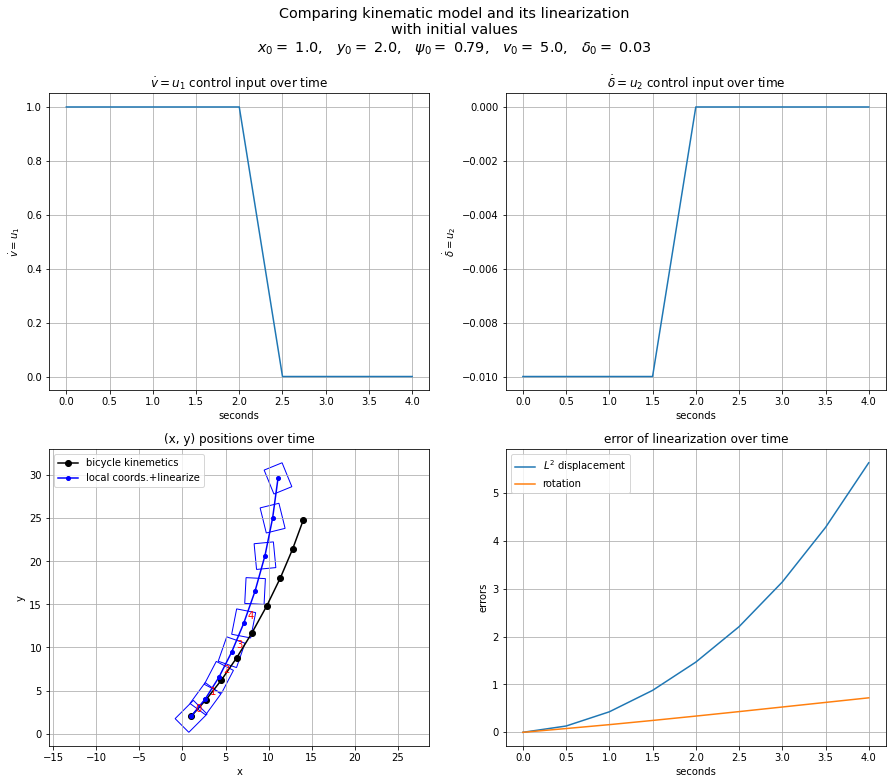

In [33]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = np.pi/4
v_0 = 5.0
delta_0 = 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: speed up and slight turn
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  , 0],
    [ 0  , 0],
    [ 0  , 0],
    [ 0  , 0],
])

plot_static_frame(initial_state, inputs, T, Ts)

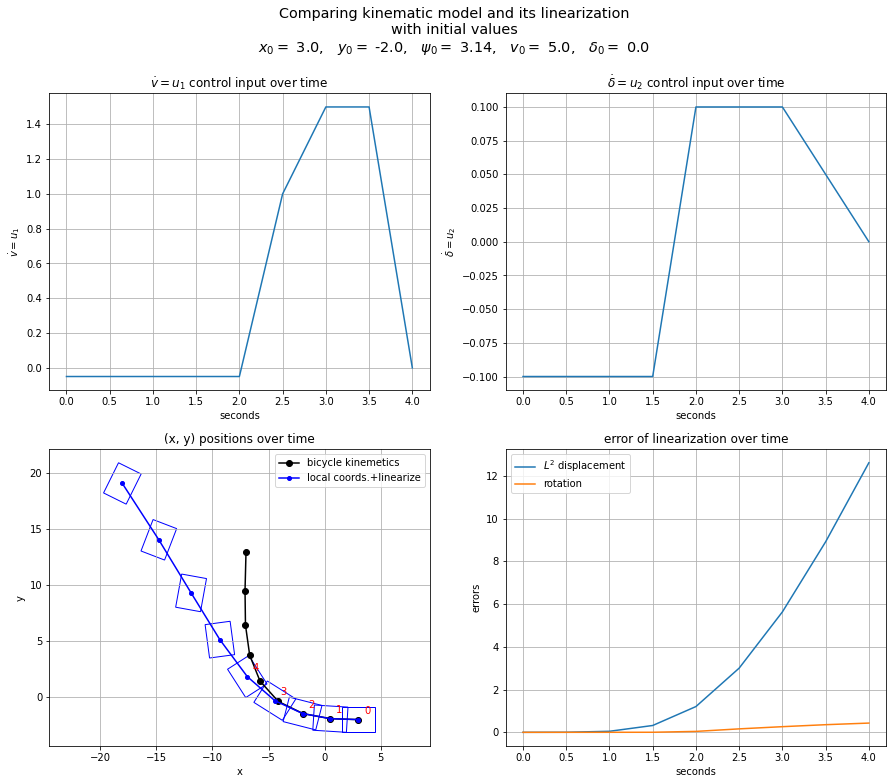

In [34]:
# initial state
x_0 = 3.
y_0 = -2.
psi_0 = np.pi
v_0 = 5.0
delta_0 = 0. # 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [-0.05,-0.1],
    [-0.05,-0.1],
    [-0.05,-0.1],
    [-0.05,-0.1],
    [-0.05, 0.1],
    [ 1   ,  0.1],
    [ 1.5 ,  0.1],
    [ 1.5 , 0.05],
])

plot_static_frame(initial_state, inputs, T, Ts)

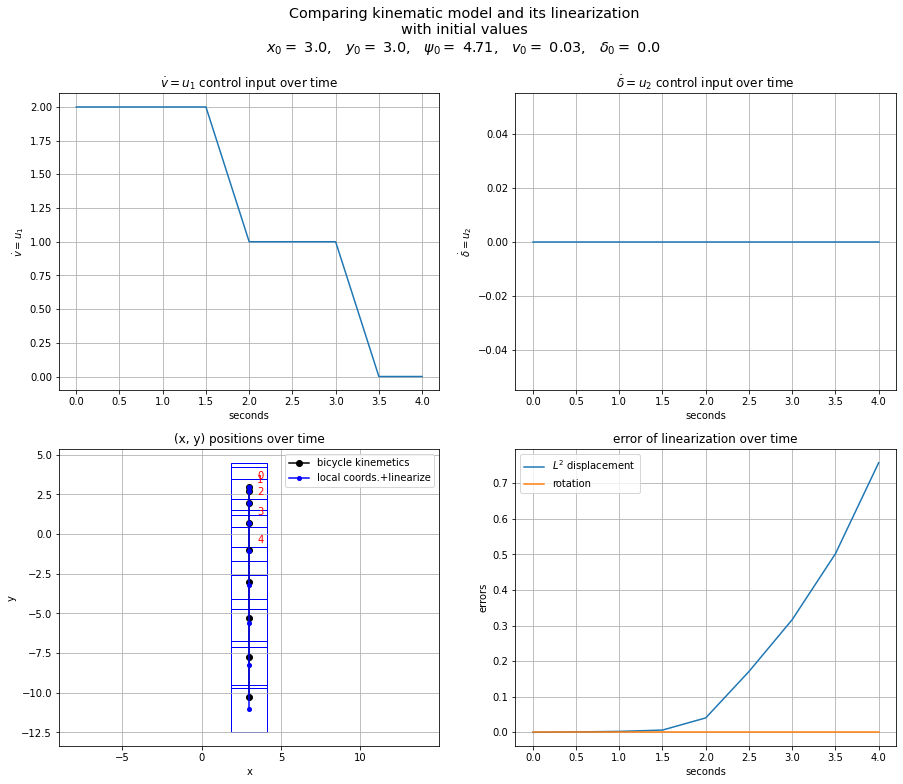

In [35]:
# initial state
x_0 = 3.
y_0 = 3.
psi_0 = (3/2)*np.pi
v_0 = 0.03
delta_0 = 0. # 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [2.0, 0],
    [2.0, 0],
    [2.0, 0],
    [2.0, 0],
    [1.0, 0],
    [1.0, 0],
    [1.0, 0],
    [0.0, 0],
])

plot_static_frame(initial_state, inputs, T, Ts)

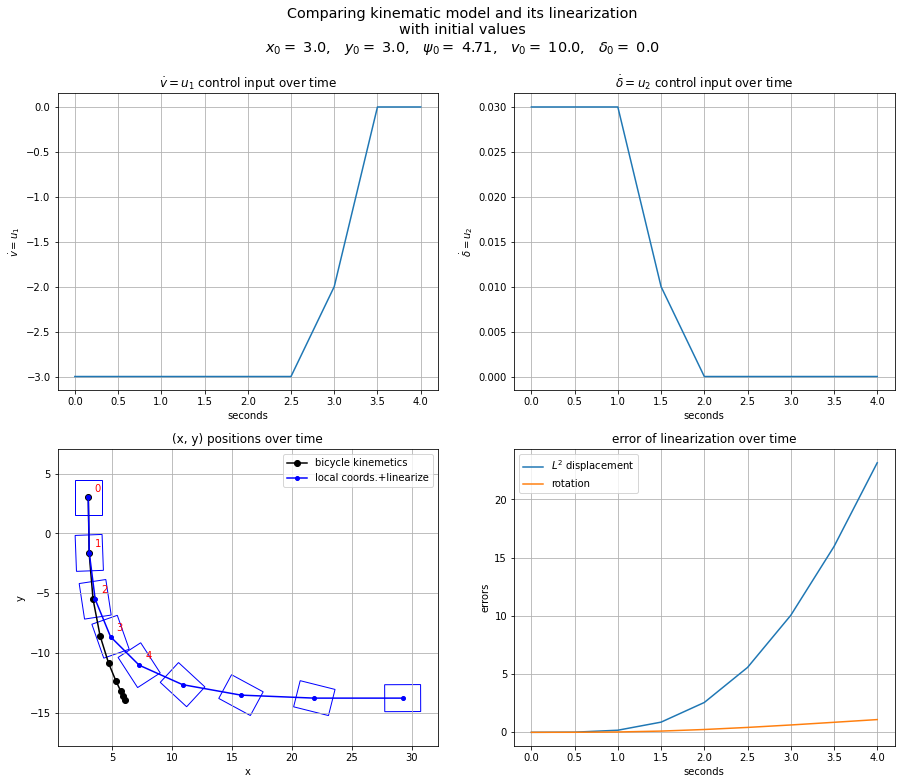

In [36]:
# initial state
x_0 = 3.
y_0 = 3.
psi_0 = (3/2)*np.pi
v_0 = 10.0
delta_0 = 0. # 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [-3.0, 0.03],
    [-3.0, 0.03],
    [-3.0, 0.03],
    [-3.0, 0.01],
    [-3.0, 0],
    [-3.0, 0],
    [-2.0, 0],
    [ 0.0, 0],
])

plot_static_frame(initial_state, inputs, T, Ts)

In [ ]:
# initial state
x_0 = 3.
y_0 = 3.
psi_0 = (3/2)*np.pi
v_0 = 10.0
delta_0 = 0. # 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs: slow down when right turn
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [-3.0, 0.03],
    [-3.0, 0.03],
    [-3.0, 0.03],
    [-3.0, 0.01],
    [-3.0, 0],
    [-3.0, 0],
    [-2.0, 0],
    [ 0.0, 0],
])

L = 1.0
l_r = 0.5

"""
initial_state : ndarray
    Initial state [x_0, y_0, psi_0, v_0, delta_0].
inputs : ndarray
    Control inputs of shape (T, 2) [u_1, u_2]
T : int
    Number of timesteps
Ts : float
    Size of each timestep
"""

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
timesteps = np.linspace(0, Ts*T, T + 1)
inputs = np.concatenate( (inputs, np.array([0, 0])[None]), axis=0).T
axes[0].plot(timesteps, inputs[0])
axes[1].plot(timesteps, inputs[1])

# change the frame so that local frame has x_0 = y_0 = 0, psi_0 = 0
x_0, y_0, psi_0, v_0, delta_0 = initial_state
initial_state_local = initial_state.copy()
initial_state_local[:3] = np.array([0, 0, 0])
# rigid transformation to convert local to global frame
M = np.array([
    [cos(psi_0), -sin(psi_0), x_0],
    [sin(psi_0),  cos(psi_0), y_0],
])
def transform(X):
    points = np.pad(X[:, :2], [(0, 0), (0, 1)], constant_values=1)
    points = points @ M.T
    psis   = X[:, 2] + psi_0
    return np.concatenate((points, psis[..., None], X[:, 3:]), axis=1)

## Plot the system without linearization

# Simulate the system (with discretization) but no linearization
io_bicycle_kinematics = control.NonlinearIOSystem(
        bicycle_kinematics, None,
        inputs=('u_1', 'u_2'),
        outputs=('x', 'y', 'psi', 'v', 'delta'),
        states=('x', 'y', 'psi', 'v', 'delta'),
        params={'l_r': l_r, 'L': L},
        name='bicycle_kinematics')
_timesteps, _states = control.input_output_response(
        # io_bicycle_kinematics, timesteps, inputs, initial_state_local)
        io_bicycle_kinematics, timesteps, inputs, initial_state)
# Plot the response
# X = transform(_states.T)
# plt.plot(X[:, 0], X[:, 1], "-ko")
axes[2].plot(_states[0], _states[1], "-ko", label="bicycle kinemetics")

## Plot the linearization x(t + 1) = A x(t) + B u(t)

# get state-space representation that linearly approximates dynamical system 
A = get_state_matrix(*initial_state_local, l_r=l_r, L=L)
B = get_input_matrix()
C = get_output_matrix()
D = get_feedforward_matrix()
# discretize state-space
sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)
A = np.array(sys.A)
B = np.array(sys.B)
nx, nu = sys.B.shape

## Plot closed form of x(t + 1) = A x(t) + B u(t)

# Closed form solution to states given inputs
# C1 has shape (nx, T*nx)
C1 = np.zeros((nx, T*nx,))
# C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
C2 = np.kron(np.eye(T - 1), A)
# C3 has shape (nx*(T - 1), nx)
C3 = np.zeros(((T - 1)*nx, nx,))
# C, Abar have shape (nx*T, nx*T)
C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
Abar = np.eye(T * nx) - C
# Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
Bbar = np.kron(np.eye(T), B)
# Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))



# make state computation account for initial position and velocity
states_init = np.concatenate([np.linalg.matrix_power(A, t) @ initial_state_local for t in range(T+1)])
u = inputs.T[:-1].ravel()
X = states_init + Gamma @ u
X = X.reshape(-1, 5)
X = transform(X)
axes[2].plot(X[:, 0], X[:, 1], "-bo", markersize=4, label="local coords.+linearize")

# car boxes
vertex_set = util.npu.vertices_of_bboxes(X[:, :2], X[:, 2], np.array([3*L, 3*0.75*L]))
for idx, vertices in enumerate(vertex_set):
    patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
    axes[2].add_patch(patch)
    # axes[2].arrow(X[idx, 0], X[idx, 1], X[idx, 3]*cos(X[idx, 2]), X[idx, 3]*sin(X[idx, 2]))

# label points with timestep
axes[2].text(*(X[0, :2] + np.array([0.5, 0.5])), "0", color="r", zorder=10)
axes[2].text(*(X[1, :2] + np.array([0.5, 0.5])), "1", color="r", zorder=10)
axes[2].text(*(X[2, :2] + np.array([0.5, 0.5])), "2", color="r", zorder=10)
axes[2].text(*(X[3, :2] + np.array([0.5, 0.5])), "3", color="r", zorder=10)
axes[2].text(*(X[4, :2] + np.array([0.5, 0.5])), "4", color="r", zorder=10)

disp_errors = np.linalg.norm(_states.T[:, :2] - X[:, :2], axis=1)
rot_errors  = np.abs(_states.T[:, 2] - X[:, 2])

axes[3].plot(timesteps, disp_errors, label="$L^2$ displacement")
axes[3].plot(timesteps, rot_errors, label="rotation")

axes[2].legend()
axes[3].legend()
axes[2].axis("equal")
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].set_title("(x, y) positions over time")
axes[0].set_xlabel("seconds")
axes[0].set_ylabel("$\dot{v} = u_1$")
axes[0].set_title("$\dot{v} = u_1$ control input over time")
axes[1].set_xlabel("seconds")
axes[1].set_ylabel("$\dot{\delta} = u_2$")
axes[1].set_title("$\dot{\delta} = u_2$ control input over time")
axes[3].set_xlabel("seconds")
axes[3].set_ylabel("errors")
axes[3].set_title("error of linearization over time")

for ax in axes:
    ax.grid()
# fig.tight_layout()
fig.suptitle("Comparing kinematic model and its linearization\n"
             "with initial values\n"
             f"$x_0 = $ {np.round(x_0, 2)},   "
             f"$y_0 = $ {np.round(y_0, 2)},   "
             f"$\psi_0 = $ {np.round(psi_0, 2)},   "
             f"$v_0 = $ {np.round(v_0, 2)},   "
             f"$\delta_0 = $ {np.round(delta_0, 2)}", size="x-large")

## Failed

In [25]:
def plot_inertial_frame(initial_state, inputs, T, Ts, L=1.0, l_r=0.5):
    """
    initial_state : ndarray
        Initial state [x_0, y_0, psi_0, v_0, delta_0].
    inputs : ndarray
        Control inputs of shape (T, 2) [u_1, u_2]
    T : int
        Number of timesteps
    Ts : float
        Size of each timestep
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    timesteps = np.linspace(0, Ts*T, T + 1)
    # change the frame so that local frame has x_0 = y_0 = 0, psi_0 = 0, v_0 = 0
    initial_state_local = initial_state.copy()
    initial_state_local[:4] = np.array([0, 0, 0, 0])
    x_0, y_0, psi_0, v_0 = initial_state[:4]
    # rigid transformation to convert local to global frame
    M = np.array([
        [cos(psi_0), -sin(psi_0), x_0],
        [sin(psi_0),  cos(psi_0), y_0],
    ])
    def transform(X):
        points = np.pad(X[:, :2], [(0, 0), (0, 1)], constant_values=1)
        points = points @ M.T
        X = np.concatenate((points, X[:, 2:]), axis=1)
        X[:, 2] += psi_0
        # X[:, :2] += np.kron(np.array([cos(psi_0), sin(psi_0)])[None], (v_0 * timesteps)[...,None])
        X[:, 3] += v_0
        return X
    inputs = np.concatenate( (inputs, np.array([0, 0])[None]), axis=0).T

    ## Plot the system without linearization in global frame

    # Simulate the system (with discretization) but no linearization
    io_bicycle_kinematics = control.NonlinearIOSystem(
            bicycle_kinematics, None,
            inputs=('u_1', 'u_2'),
            outputs=('x', 'y', 'psi', 'v', 'delta'),
            states=('x', 'y', 'psi', 'v', 'delta'),
            params={'l_r': l_r, 'L': L},
            name='bicycle_kinematics')
    _timesteps, _states = control.input_output_response(
            io_bicycle_kinematics, timesteps, inputs, initial_state)
    # Plot the response
    axes[1].plot(_states[0], _states[1], "-ko")
    
    ## Plot the system without linearization in inertial frame
    
    # Simulate the system (with discretization) but no linearization
    io_bicycle_kinematics = control.NonlinearIOSystem(
            bicycle_kinematics, None,
            inputs=('u_1', 'u_2'),
            outputs=('x', 'y', 'psi', 'v', 'delta'),
            states=('x', 'y', 'psi', 'v', 'delta'),
            params={'l_r': l_r, 'L': L},
            name='bicycle_kinematics')
    _timesteps, _states = control.input_output_response(
            io_bicycle_kinematics, timesteps, inputs, initial_state_local)
            # io_bicycle_kinematics, timesteps, inputs, initial_state)
    # Plot the response
    X = transform(_states.T)
    axes[0].plot(X[:, 0], X[:, 1], "-ko")

    ## Plot the linearization x(t + 1) = A x(t) + B u(t)

    # get state-space representation that linearly approximates dynamical system 
    A = get_state_matrix(*initial_state_local, l_r=l_r, L=L)
    B = get_input_matrix()
    C = get_output_matrix()
    D = get_feedforward_matrix()
    # discretize state-space
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)
    A = np.array(sys.A)
    B = np.array(sys.B)
    nx, nu = sys.B.shape

    ## Plot closed form of x(t + 1) = A x(t) + B u(t)

    # Closed form solution to states given inputs
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))

    # make state computation account for initial position and velocity
    states_init = np.concatenate([np.linalg.matrix_power(A, t) @ initial_state_local for t in range(T+1)])
    u = inputs.T[:-1].ravel()
    X = states_init + Gamma @ u
    X = X.reshape(-1, 5)
    X = transform(X)
#     axes[0].plot(X[:, 0], X[:, 1], "-bo", markersize=4)
    for ax in axes:
        ax.axis("equal")



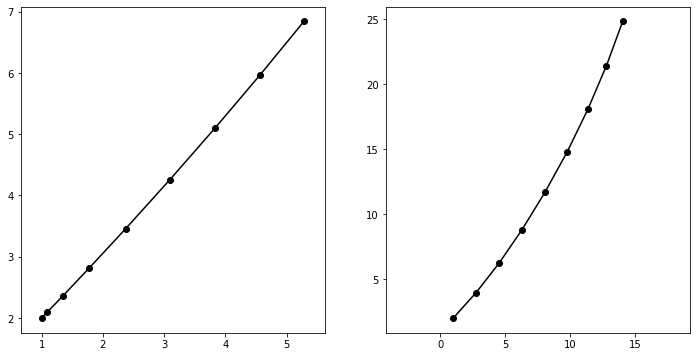

In [313]:
# initial state
x_0 = 1.
y_0 = 2.
psi_0 = np.pi/4
v_0 = 5.0
delta_0 = 0.02*0.5*np.pi
initial_state = [x_0, y_0, psi_0, v_0, delta_0]
# time parameters
T = 8
Ts = 0.5
timesteps = np.linspace(0, Ts*T, T + 1)
# inputs
# note that radians 0.5*np.pi / 6 = 0.26
inputs = np.array([
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  ,-0.01],
    [ 1  , 0],
    [ 0  , 0],
    [ 0  , 0],
    [ 0  , 0],
])

plot_inertial_frame(initial_state, inputs, T, Ts)